# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [8]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

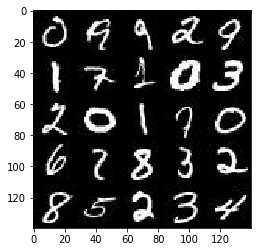

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

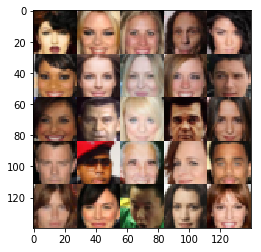

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate=tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # The discriminator uses the DCGAN architecture. Batch normalization is
        # used on all layers except the first convolutional layer and the output layer.
        # Shape of images: 28x28x3 (CelebA) or 28x28x1 (MNIST)
        
        # First convolutional layer.
        # Resulting shape: 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # Second convolutional layer.
        # Resulting shape: 7x7x128
        x2 = tf.layers.conv2d(x1, 128, (5,5), 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Third convolutional layer.
        # Note: According to the TensorFlow documentation, a ceiling operator
        # is applied to the output width and height when using SAME padding.
        # That's why the width and height of 7 are downscaled to 4.
        # See https://www.tensorflow.org/api_guides/python/nn#Convolution.
        # Resulting shape: 4x4x256
        x3 = tf.layers.conv2d(x2, 256, (5,5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    # Only reuse variables if we're not training the network.
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer.
        # Resulting shape: 4x4x512
        x1 = tf.layers.dense(inputs=z, units=4*4*512, activation=None)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # First convolutional layer.
        # This forum post describes how to get from 4x4 to 7x7: http://bit.ly/2vkOFCv.
        # Resulting shape: 7x7x256
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=256, kernel_size=(4, 4), strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Second convolutional layer.
        # Resulting shape: 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 256, (5, 5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer.
        # Resulting shape: 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5, 5), 2, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Wether or not to use label smoothing.
    use_label_smoothing = True
    
    # The label smoothing factor used to help the discriminator generalize better.
    smooth = 0.1

    # The generator output.
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # The discriminator output and logits when fed the real and fake images.
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the discriminator loss.
    # ---------------------------------
    # For real images, the labels are all ones (because they are the real images).
    if use_label_smoothing:
        d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    else:
        d_labels_real = tf.ones_like(d_model_real)
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real)
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    # For fake images, the labels are all zeros (because they are the fake images).
    d_lables_fake = tf.zeros_like(d_model_fake) * (1 - smooth)
    d_cross_entroy_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_lables_fake)
    d_loss_fake = tf.reduce_mean(d_cross_entroy_fake)
    
    # Calculate the total loss.
    d_loss = d_loss_real + d_loss_fake
    
    # Calculate the generator loss.
    # -----------------------------
    # Remember, the generator is trying to fool the discriminator into outputting
    # ones for fake images. That's why the labels are set to all ones for the fake output.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and biases to update, separately for the discriminator and the generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run the optimizer on the respective discriminator and generator variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print("data_shape={}".format(data_shape))
    print("data_image_mode={}".format(data_image_mode))
    
    # saver = tf.train.Saver()
    
    # Build the model.
    # ----------------
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Train the model.
    # ----------------
    batch_i = 0
    losses = []
    n_images = 25
    show_losses_every = 10
    show_output_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Rescale images from (-0.5, 0.5) to (-1, 1), because we're using the
                # tanh activation function in the generator which has a range of (-1, 1).
                batch_images = batch_images * 2

                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run the optimizers on both the discriminator and the generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # Note_ We need to pass the values for the placeholders 'input_real'
                # and 'lr' here to satisfy TensorFlow. They aren't actually used.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                # Print losses every 25 batches.
                if batch_i % show_losses_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}...".format(batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # Save losses to view after training.
                    losses.append((train_loss_d, train_loss_g))

                # Print generator output every 100 batches.
                if batch_i % show_output_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
            print("Batches per epoch: {}".format(batch_i))    
            
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        # saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape=(60000, 28, 28, 1)
data_image_mode=L
Epoch 1/2... Batch 10... Discriminator Loss: 1.2002... Generator Loss: 0.6584
Epoch 1/2... Batch 20... Discriminator Loss: 0.7029... Generator Loss: 1.3699
Epoch 1/2... Batch 30... Discriminator Loss: 0.5652... Generator Loss: 1.7648
Epoch 1/2... Batch 40... Discriminator Loss: 0.4251... Generator Loss: 3.0316
Epoch 1/2... Batch 50... Discriminator Loss: 0.4919... Generator Loss: 6.2073
Epoch 1/2... Batch 60... Discriminator Loss: 1.1808... Generator Loss: 10.2390
Epoch 1/2... Batch 70... Discriminator Loss: 2.0002... Generator Loss: 0.5791
Epoch 1/2... Batch 80... Discriminator Loss: 0.5313... Generator Loss: 2.9222
Epoch 1/2... Batch 90... Discriminator Loss: 0.4042... Generator Loss: 3.7327
Epoch 1/2... Batch 100... Discriminator Loss: 0.5325... Generator Loss: 2.4811


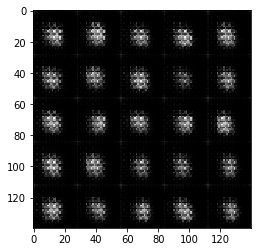

Epoch 1/2... Batch 110... Discriminator Loss: 0.4721... Generator Loss: 3.0711
Epoch 1/2... Batch 120... Discriminator Loss: 0.4875... Generator Loss: 2.7745
Epoch 1/2... Batch 130... Discriminator Loss: 0.5303... Generator Loss: 2.4767
Epoch 1/2... Batch 140... Discriminator Loss: 0.5501... Generator Loss: 2.1844
Epoch 1/2... Batch 150... Discriminator Loss: 0.5866... Generator Loss: 2.1999
Epoch 1/2... Batch 160... Discriminator Loss: 0.5412... Generator Loss: 2.9360
Epoch 1/2... Batch 170... Discriminator Loss: 0.6923... Generator Loss: 1.5861
Epoch 1/2... Batch 180... Discriminator Loss: 0.6336... Generator Loss: 2.2232
Epoch 1/2... Batch 190... Discriminator Loss: 0.6564... Generator Loss: 3.1657
Epoch 1/2... Batch 200... Discriminator Loss: 0.5041... Generator Loss: 3.7153


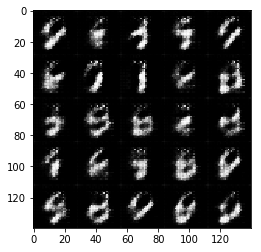

Epoch 1/2... Batch 210... Discriminator Loss: 0.7664... Generator Loss: 2.4133
Epoch 1/2... Batch 220... Discriminator Loss: 0.9050... Generator Loss: 1.6791
Epoch 1/2... Batch 230... Discriminator Loss: 1.1028... Generator Loss: 5.2070
Epoch 1/2... Batch 240... Discriminator Loss: 0.8651... Generator Loss: 1.4936
Epoch 1/2... Batch 250... Discriminator Loss: 0.9191... Generator Loss: 1.1005
Epoch 1/2... Batch 260... Discriminator Loss: 1.0647... Generator Loss: 1.4274
Epoch 1/2... Batch 270... Discriminator Loss: 0.8564... Generator Loss: 1.4300
Epoch 1/2... Batch 280... Discriminator Loss: 0.8727... Generator Loss: 1.1960
Epoch 1/2... Batch 290... Discriminator Loss: 0.8836... Generator Loss: 1.4862
Epoch 1/2... Batch 300... Discriminator Loss: 0.9563... Generator Loss: 1.6746


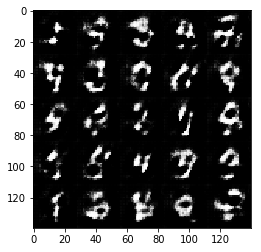

Epoch 1/2... Batch 310... Discriminator Loss: 0.8285... Generator Loss: 2.2063
Epoch 1/2... Batch 320... Discriminator Loss: 0.7529... Generator Loss: 2.0834
Epoch 1/2... Batch 330... Discriminator Loss: 0.9195... Generator Loss: 1.7040
Epoch 1/2... Batch 340... Discriminator Loss: 0.9798... Generator Loss: 1.1162
Epoch 1/2... Batch 350... Discriminator Loss: 0.8315... Generator Loss: 1.5400
Epoch 1/2... Batch 360... Discriminator Loss: 0.8475... Generator Loss: 1.4220
Epoch 1/2... Batch 370... Discriminator Loss: 0.9487... Generator Loss: 1.4106
Epoch 1/2... Batch 380... Discriminator Loss: 1.3935... Generator Loss: 2.6597
Epoch 1/2... Batch 390... Discriminator Loss: 0.8970... Generator Loss: 1.1635
Epoch 1/2... Batch 400... Discriminator Loss: 0.9267... Generator Loss: 1.1727


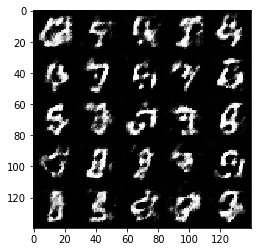

Epoch 1/2... Batch 410... Discriminator Loss: 1.0279... Generator Loss: 1.1387
Epoch 1/2... Batch 420... Discriminator Loss: 1.1095... Generator Loss: 1.7017
Epoch 1/2... Batch 430... Discriminator Loss: 1.0587... Generator Loss: 0.9023
Epoch 1/2... Batch 440... Discriminator Loss: 0.9757... Generator Loss: 1.8208
Epoch 1/2... Batch 450... Discriminator Loss: 1.1823... Generator Loss: 0.7283
Epoch 1/2... Batch 460... Discriminator Loss: 0.9606... Generator Loss: 1.2772
Batches per epoch: 468
Epoch 2/2... Batch 470... Discriminator Loss: 1.0753... Generator Loss: 1.9856
Epoch 2/2... Batch 480... Discriminator Loss: 0.9526... Generator Loss: 1.6346
Epoch 2/2... Batch 490... Discriminator Loss: 1.2737... Generator Loss: 2.0855
Epoch 2/2... Batch 500... Discriminator Loss: 0.8940... Generator Loss: 1.6787


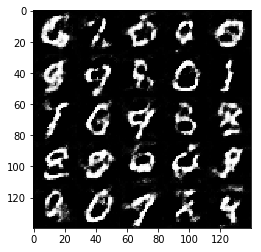

Epoch 2/2... Batch 510... Discriminator Loss: 1.1214... Generator Loss: 0.7527
Epoch 2/2... Batch 520... Discriminator Loss: 1.0279... Generator Loss: 1.7538
Epoch 2/2... Batch 530... Discriminator Loss: 0.9655... Generator Loss: 0.9700
Epoch 2/2... Batch 540... Discriminator Loss: 1.0459... Generator Loss: 0.8886
Epoch 2/2... Batch 550... Discriminator Loss: 1.0390... Generator Loss: 1.4299
Epoch 2/2... Batch 560... Discriminator Loss: 1.1566... Generator Loss: 0.7262
Epoch 2/2... Batch 570... Discriminator Loss: 1.0193... Generator Loss: 1.2902
Epoch 2/2... Batch 580... Discriminator Loss: 1.0941... Generator Loss: 0.8122
Epoch 2/2... Batch 590... Discriminator Loss: 1.1632... Generator Loss: 0.7253
Epoch 2/2... Batch 600... Discriminator Loss: 1.0143... Generator Loss: 0.9337


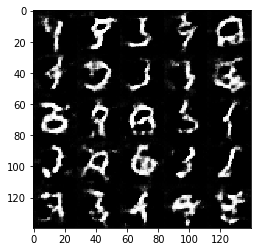

Epoch 2/2... Batch 610... Discriminator Loss: 0.9817... Generator Loss: 1.1768
Epoch 2/2... Batch 620... Discriminator Loss: 1.0264... Generator Loss: 1.2199
Epoch 2/2... Batch 630... Discriminator Loss: 1.1637... Generator Loss: 0.7567
Epoch 2/2... Batch 640... Discriminator Loss: 1.0886... Generator Loss: 1.6645
Epoch 2/2... Batch 650... Discriminator Loss: 0.9739... Generator Loss: 1.2595
Epoch 2/2... Batch 660... Discriminator Loss: 1.1260... Generator Loss: 0.7610
Epoch 2/2... Batch 670... Discriminator Loss: 1.0819... Generator Loss: 0.8379
Epoch 2/2... Batch 680... Discriminator Loss: 0.9365... Generator Loss: 1.1256
Epoch 2/2... Batch 690... Discriminator Loss: 1.1840... Generator Loss: 0.6703
Epoch 2/2... Batch 700... Discriminator Loss: 1.0222... Generator Loss: 0.9810


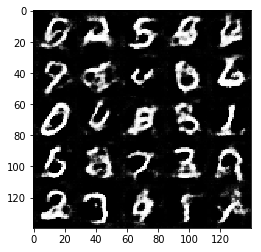

Epoch 2/2... Batch 710... Discriminator Loss: 1.0082... Generator Loss: 0.9512
Epoch 2/2... Batch 720... Discriminator Loss: 1.2086... Generator Loss: 0.6555
Epoch 2/2... Batch 730... Discriminator Loss: 0.9526... Generator Loss: 1.2266
Epoch 2/2... Batch 740... Discriminator Loss: 0.9631... Generator Loss: 1.6209
Epoch 2/2... Batch 750... Discriminator Loss: 0.9621... Generator Loss: 1.1342
Epoch 2/2... Batch 760... Discriminator Loss: 1.0245... Generator Loss: 0.9050
Epoch 2/2... Batch 770... Discriminator Loss: 1.0683... Generator Loss: 0.8555
Epoch 2/2... Batch 780... Discriminator Loss: 0.9303... Generator Loss: 1.3685
Epoch 2/2... Batch 790... Discriminator Loss: 1.0963... Generator Loss: 2.0883
Epoch 2/2... Batch 800... Discriminator Loss: 0.9444... Generator Loss: 1.2978


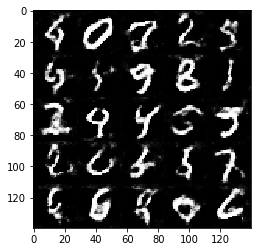

Epoch 2/2... Batch 810... Discriminator Loss: 1.2550... Generator Loss: 0.6165
Epoch 2/2... Batch 820... Discriminator Loss: 1.0178... Generator Loss: 0.9046
Epoch 2/2... Batch 830... Discriminator Loss: 0.9906... Generator Loss: 1.8013
Epoch 2/2... Batch 840... Discriminator Loss: 0.9903... Generator Loss: 1.8528
Epoch 2/2... Batch 850... Discriminator Loss: 0.9064... Generator Loss: 1.2820
Epoch 2/2... Batch 860... Discriminator Loss: 0.9139... Generator Loss: 1.2719
Epoch 2/2... Batch 870... Discriminator Loss: 1.0777... Generator Loss: 2.0685
Epoch 2/2... Batch 880... Discriminator Loss: 1.1060... Generator Loss: 0.7665
Epoch 2/2... Batch 890... Discriminator Loss: 1.0723... Generator Loss: 0.8019
Epoch 2/2... Batch 900... Discriminator Loss: 0.9750... Generator Loss: 0.9491


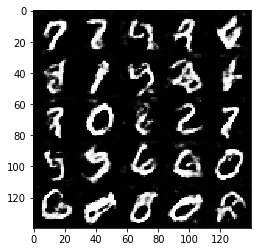

Epoch 2/2... Batch 910... Discriminator Loss: 0.9553... Generator Loss: 1.0737
Epoch 2/2... Batch 920... Discriminator Loss: 1.0072... Generator Loss: 1.6005
Epoch 2/2... Batch 930... Discriminator Loss: 0.8959... Generator Loss: 1.1171
Batches per epoch: 936


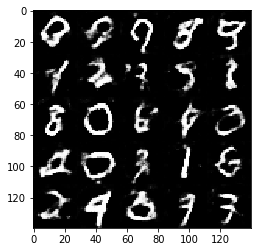

In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, 
                         mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

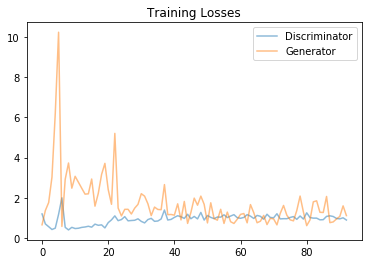

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

losses_mnist = np.array(losses_mnist)
plt.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape=(202599, 28, 28, 3)
data_image_mode=RGB
Epoch 1/1... Batch 10... Discriminator Loss: 0.9356... Generator Loss: 2.0061
Epoch 1/1... Batch 20... Discriminator Loss: 0.7605... Generator Loss: 1.6913
Epoch 1/1... Batch 30... Discriminator Loss: 0.6029... Generator Loss: 2.1370
Epoch 1/1... Batch 40... Discriminator Loss: 0.6087... Generator Loss: 2.4328
Epoch 1/1... Batch 50... Discriminator Loss: 1.1428... Generator Loss: 0.6709
Epoch 1/1... Batch 60... Discriminator Loss: 0.6452... Generator Loss: 1.8663
Epoch 1/1... Batch 70... Discriminator Loss: 0.5134... Generator Loss: 2.5407
Epoch 1/1... Batch 80... Discriminator Loss: 0.5431... Generator Loss: 3.0740
Epoch 1/1... Batch 90... Discriminator Loss: 0.5914... Generator Loss: 1.9154
Epoch 1/1... Batch 100... Discriminator Loss: 0.5995... Generator Loss: 3.0850


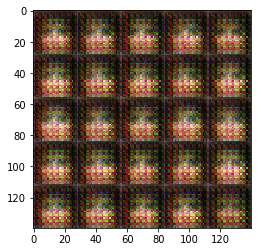

Epoch 1/1... Batch 110... Discriminator Loss: 0.5948... Generator Loss: 1.6577
Epoch 1/1... Batch 120... Discriminator Loss: 0.4681... Generator Loss: 2.7069
Epoch 1/1... Batch 130... Discriminator Loss: 0.8582... Generator Loss: 1.0909
Epoch 1/1... Batch 140... Discriminator Loss: 0.6052... Generator Loss: 2.1204
Epoch 1/1... Batch 150... Discriminator Loss: 0.8670... Generator Loss: 1.1996
Epoch 1/1... Batch 160... Discriminator Loss: 0.6801... Generator Loss: 1.4641
Epoch 1/1... Batch 170... Discriminator Loss: 0.5925... Generator Loss: 2.4586
Epoch 1/1... Batch 180... Discriminator Loss: 0.6501... Generator Loss: 2.2590
Epoch 1/1... Batch 190... Discriminator Loss: 0.6109... Generator Loss: 1.8607
Epoch 1/1... Batch 200... Discriminator Loss: 0.8027... Generator Loss: 4.5335


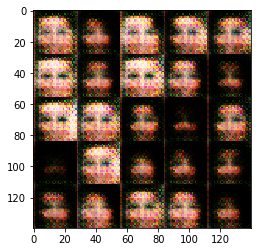

Epoch 1/1... Batch 210... Discriminator Loss: 0.8879... Generator Loss: 1.1931
Epoch 1/1... Batch 220... Discriminator Loss: 0.6168... Generator Loss: 2.6107
Epoch 1/1... Batch 230... Discriminator Loss: 0.6505... Generator Loss: 2.3206
Epoch 1/1... Batch 240... Discriminator Loss: 0.6991... Generator Loss: 1.6877
Epoch 1/1... Batch 250... Discriminator Loss: 1.2493... Generator Loss: 4.1379
Epoch 1/1... Batch 260... Discriminator Loss: 0.9894... Generator Loss: 1.7000
Epoch 1/1... Batch 270... Discriminator Loss: 1.1903... Generator Loss: 1.4070
Epoch 1/1... Batch 280... Discriminator Loss: 0.8080... Generator Loss: 1.7585
Epoch 1/1... Batch 290... Discriminator Loss: 1.0194... Generator Loss: 2.1887
Epoch 1/1... Batch 300... Discriminator Loss: 0.7780... Generator Loss: 1.6839


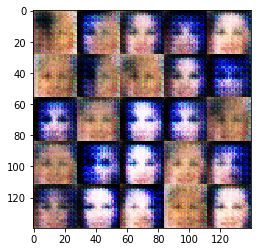

Epoch 1/1... Batch 310... Discriminator Loss: 1.7263... Generator Loss: 3.6145
Epoch 1/1... Batch 320... Discriminator Loss: 1.1309... Generator Loss: 0.9323
Epoch 1/1... Batch 330... Discriminator Loss: 1.0825... Generator Loss: 0.9963
Epoch 1/1... Batch 340... Discriminator Loss: 1.1388... Generator Loss: 2.1520
Epoch 1/1... Batch 350... Discriminator Loss: 1.0812... Generator Loss: 0.9151
Epoch 1/1... Batch 360... Discriminator Loss: 1.0969... Generator Loss: 1.6209
Epoch 1/1... Batch 370... Discriminator Loss: 0.9166... Generator Loss: 1.2173
Epoch 1/1... Batch 380... Discriminator Loss: 1.0369... Generator Loss: 1.3919
Epoch 1/1... Batch 390... Discriminator Loss: 0.7168... Generator Loss: 2.4157
Epoch 1/1... Batch 400... Discriminator Loss: 0.8318... Generator Loss: 1.5451


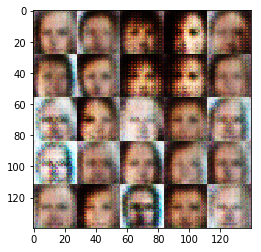

Epoch 1/1... Batch 410... Discriminator Loss: 0.8803... Generator Loss: 1.1854
Epoch 1/1... Batch 420... Discriminator Loss: 1.0336... Generator Loss: 0.8653
Epoch 1/1... Batch 430... Discriminator Loss: 1.0804... Generator Loss: 0.9347
Epoch 1/1... Batch 440... Discriminator Loss: 0.8307... Generator Loss: 1.3958
Epoch 1/1... Batch 450... Discriminator Loss: 0.8440... Generator Loss: 1.6803
Epoch 1/1... Batch 460... Discriminator Loss: 0.8970... Generator Loss: 1.7563
Epoch 1/1... Batch 470... Discriminator Loss: 0.7487... Generator Loss: 2.7511
Epoch 1/1... Batch 480... Discriminator Loss: 1.0545... Generator Loss: 1.2188
Epoch 1/1... Batch 490... Discriminator Loss: 1.1046... Generator Loss: 2.1551
Epoch 1/1... Batch 500... Discriminator Loss: 1.1635... Generator Loss: 3.4424


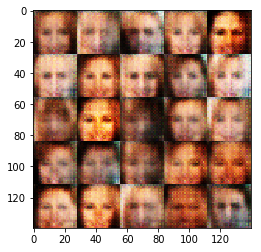

Epoch 1/1... Batch 510... Discriminator Loss: 1.1256... Generator Loss: 1.5898
Epoch 1/1... Batch 520... Discriminator Loss: 0.7892... Generator Loss: 2.1986
Epoch 1/1... Batch 530... Discriminator Loss: 0.9486... Generator Loss: 2.5131
Epoch 1/1... Batch 540... Discriminator Loss: 0.9413... Generator Loss: 2.2939
Epoch 1/1... Batch 550... Discriminator Loss: 1.5418... Generator Loss: 3.3114
Epoch 1/1... Batch 560... Discriminator Loss: 1.2750... Generator Loss: 0.9812
Epoch 1/1... Batch 570... Discriminator Loss: 0.9875... Generator Loss: 2.1851
Epoch 1/1... Batch 580... Discriminator Loss: 1.4562... Generator Loss: 0.5105
Epoch 1/1... Batch 590... Discriminator Loss: 1.2381... Generator Loss: 0.7687
Epoch 1/1... Batch 600... Discriminator Loss: 1.0500... Generator Loss: 1.5609


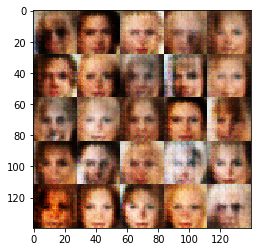

Epoch 1/1... Batch 610... Discriminator Loss: 0.8020... Generator Loss: 2.1656
Epoch 1/1... Batch 620... Discriminator Loss: 0.9690... Generator Loss: 1.1412
Epoch 1/1... Batch 630... Discriminator Loss: 1.6016... Generator Loss: 0.4525
Epoch 1/1... Batch 640... Discriminator Loss: 0.9338... Generator Loss: 2.9043
Epoch 1/1... Batch 650... Discriminator Loss: 1.1256... Generator Loss: 0.8845
Epoch 1/1... Batch 660... Discriminator Loss: 0.8767... Generator Loss: 1.4834
Epoch 1/1... Batch 670... Discriminator Loss: 0.9047... Generator Loss: 1.7505
Epoch 1/1... Batch 680... Discriminator Loss: 1.2326... Generator Loss: 0.6590
Epoch 1/1... Batch 690... Discriminator Loss: 0.7666... Generator Loss: 1.9462
Epoch 1/1... Batch 700... Discriminator Loss: 1.4074... Generator Loss: 0.6376


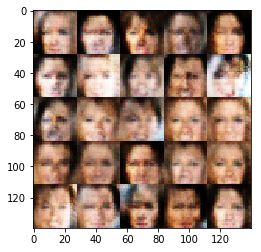

Epoch 1/1... Batch 710... Discriminator Loss: 1.2709... Generator Loss: 2.8295
Epoch 1/1... Batch 720... Discriminator Loss: 1.3762... Generator Loss: 0.5016
Epoch 1/1... Batch 730... Discriminator Loss: 1.0147... Generator Loss: 1.0688
Epoch 1/1... Batch 740... Discriminator Loss: 0.5515... Generator Loss: 3.6972
Epoch 1/1... Batch 750... Discriminator Loss: 0.9830... Generator Loss: 0.8949
Epoch 1/1... Batch 760... Discriminator Loss: 0.9131... Generator Loss: 1.5757
Epoch 1/1... Batch 770... Discriminator Loss: 0.7950... Generator Loss: 1.8556
Epoch 1/1... Batch 780... Discriminator Loss: 0.7866... Generator Loss: 1.7836
Epoch 1/1... Batch 790... Discriminator Loss: 0.7781... Generator Loss: 1.2446
Epoch 1/1... Batch 800... Discriminator Loss: 0.9585... Generator Loss: 0.9829


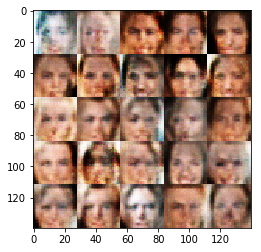

Epoch 1/1... Batch 810... Discriminator Loss: 0.8944... Generator Loss: 1.1584
Epoch 1/1... Batch 820... Discriminator Loss: 0.8030... Generator Loss: 3.0251
Epoch 1/1... Batch 830... Discriminator Loss: 0.6784... Generator Loss: 1.5153
Epoch 1/1... Batch 840... Discriminator Loss: 1.3521... Generator Loss: 1.9340
Epoch 1/1... Batch 850... Discriminator Loss: 0.9796... Generator Loss: 0.9767
Epoch 1/1... Batch 860... Discriminator Loss: 0.7570... Generator Loss: 1.7802
Epoch 1/1... Batch 870... Discriminator Loss: 0.6838... Generator Loss: 2.6205
Epoch 1/1... Batch 880... Discriminator Loss: 0.4667... Generator Loss: 3.2484
Epoch 1/1... Batch 890... Discriminator Loss: 1.7440... Generator Loss: 0.3636
Epoch 1/1... Batch 900... Discriminator Loss: 1.0515... Generator Loss: 3.9338


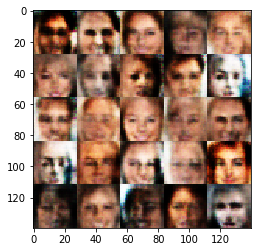

Epoch 1/1... Batch 910... Discriminator Loss: 0.4259... Generator Loss: 3.1063
Epoch 1/1... Batch 920... Discriminator Loss: 0.6732... Generator Loss: 2.6295
Epoch 1/1... Batch 930... Discriminator Loss: 0.4174... Generator Loss: 3.5625
Epoch 1/1... Batch 940... Discriminator Loss: 0.6006... Generator Loss: 1.6421
Epoch 1/1... Batch 950... Discriminator Loss: 0.4500... Generator Loss: 3.5264
Epoch 1/1... Batch 960... Discriminator Loss: 0.5239... Generator Loss: 3.1102
Epoch 1/1... Batch 970... Discriminator Loss: 1.1627... Generator Loss: 2.8656
Epoch 1/1... Batch 980... Discriminator Loss: 0.6490... Generator Loss: 3.5296
Epoch 1/1... Batch 990... Discriminator Loss: 0.9712... Generator Loss: 0.9804
Epoch 1/1... Batch 1000... Discriminator Loss: 0.5058... Generator Loss: 2.9588


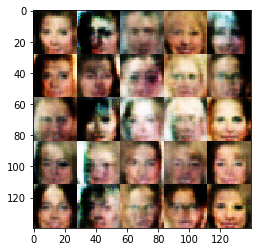

Epoch 1/1... Batch 1010... Discriminator Loss: 0.6959... Generator Loss: 3.0798
Epoch 1/1... Batch 1020... Discriminator Loss: 0.7044... Generator Loss: 1.5593
Epoch 1/1... Batch 1030... Discriminator Loss: 1.0064... Generator Loss: 0.9973
Epoch 1/1... Batch 1040... Discriminator Loss: 0.4904... Generator Loss: 2.2502
Epoch 1/1... Batch 1050... Discriminator Loss: 0.4784... Generator Loss: 2.8572
Epoch 1/1... Batch 1060... Discriminator Loss: 0.4511... Generator Loss: 2.6932
Epoch 1/1... Batch 1070... Discriminator Loss: 1.0897... Generator Loss: 4.2288
Epoch 1/1... Batch 1080... Discriminator Loss: 0.6955... Generator Loss: 1.4644
Epoch 1/1... Batch 1090... Discriminator Loss: 0.5834... Generator Loss: 3.5173
Epoch 1/1... Batch 1100... Discriminator Loss: 0.4569... Generator Loss: 3.0504


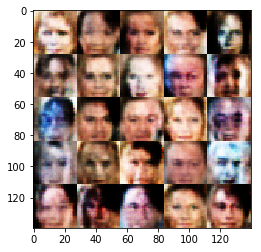

Epoch 1/1... Batch 1110... Discriminator Loss: 0.8813... Generator Loss: 0.9591
Epoch 1/1... Batch 1120... Discriminator Loss: 0.4890... Generator Loss: 3.3394
Epoch 1/1... Batch 1130... Discriminator Loss: 0.7525... Generator Loss: 1.1964
Epoch 1/1... Batch 1140... Discriminator Loss: 0.5718... Generator Loss: 1.8082
Epoch 1/1... Batch 1150... Discriminator Loss: 0.4762... Generator Loss: 2.6019
Epoch 1/1... Batch 1160... Discriminator Loss: 0.4599... Generator Loss: 2.7400
Epoch 1/1... Batch 1170... Discriminator Loss: 0.9920... Generator Loss: 0.8203
Epoch 1/1... Batch 1180... Discriminator Loss: 0.5715... Generator Loss: 2.0289
Epoch 1/1... Batch 1190... Discriminator Loss: 0.4783... Generator Loss: 2.1682
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8423... Generator Loss: 1.0637


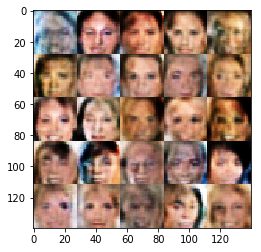

Epoch 1/1... Batch 1210... Discriminator Loss: 0.6293... Generator Loss: 3.8748
Epoch 1/1... Batch 1220... Discriminator Loss: 0.5609... Generator Loss: 1.8720
Epoch 1/1... Batch 1230... Discriminator Loss: 0.6723... Generator Loss: 1.4521
Epoch 1/1... Batch 1240... Discriminator Loss: 0.4306... Generator Loss: 4.7595
Epoch 1/1... Batch 1250... Discriminator Loss: 0.7153... Generator Loss: 1.3390
Epoch 1/1... Batch 1260... Discriminator Loss: 0.6734... Generator Loss: 1.4714
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9076... Generator Loss: 3.4840
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3479... Generator Loss: 3.9519
Epoch 1/1... Batch 1290... Discriminator Loss: 0.6378... Generator Loss: 1.6729
Epoch 1/1... Batch 1300... Discriminator Loss: 0.3790... Generator Loss: 4.1232


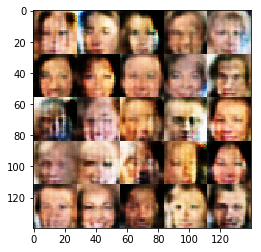

Epoch 1/1... Batch 1310... Discriminator Loss: 0.6339... Generator Loss: 1.7423
Epoch 1/1... Batch 1320... Discriminator Loss: 1.0186... Generator Loss: 0.8295
Epoch 1/1... Batch 1330... Discriminator Loss: 0.7624... Generator Loss: 1.3041
Epoch 1/1... Batch 1340... Discriminator Loss: 0.4110... Generator Loss: 5.1101
Epoch 1/1... Batch 1350... Discriminator Loss: 0.5319... Generator Loss: 2.1338
Epoch 1/1... Batch 1360... Discriminator Loss: 0.6575... Generator Loss: 1.4406
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0969... Generator Loss: 4.1890
Epoch 1/1... Batch 1380... Discriminator Loss: 0.7382... Generator Loss: 2.4381
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8068... Generator Loss: 1.0974
Epoch 1/1... Batch 1400... Discriminator Loss: 0.6620... Generator Loss: 1.4414


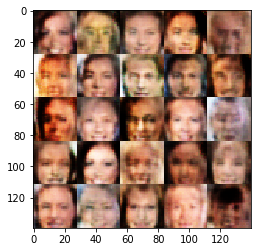

Epoch 1/1... Batch 1410... Discriminator Loss: 0.6934... Generator Loss: 1.4265
Epoch 1/1... Batch 1420... Discriminator Loss: 0.4496... Generator Loss: 3.6282
Epoch 1/1... Batch 1430... Discriminator Loss: 0.5164... Generator Loss: 2.3730
Epoch 1/1... Batch 1440... Discriminator Loss: 0.7057... Generator Loss: 2.4300
Epoch 1/1... Batch 1450... Discriminator Loss: 1.0841... Generator Loss: 0.7164
Epoch 1/1... Batch 1460... Discriminator Loss: 0.5976... Generator Loss: 1.8562
Epoch 1/1... Batch 1470... Discriminator Loss: 0.7100... Generator Loss: 1.3606
Epoch 1/1... Batch 1480... Discriminator Loss: 0.4187... Generator Loss: 3.3905
Epoch 1/1... Batch 1490... Discriminator Loss: 0.8036... Generator Loss: 1.1296
Epoch 1/1... Batch 1500... Discriminator Loss: 0.5812... Generator Loss: 2.2252


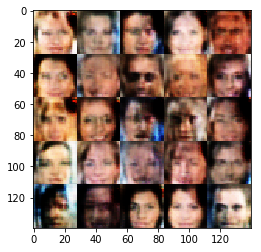

Epoch 1/1... Batch 1510... Discriminator Loss: 0.8210... Generator Loss: 1.1263
Epoch 1/1... Batch 1520... Discriminator Loss: 0.4090... Generator Loss: 3.2332
Epoch 1/1... Batch 1530... Discriminator Loss: 0.6426... Generator Loss: 1.7858
Epoch 1/1... Batch 1540... Discriminator Loss: 0.8916... Generator Loss: 3.3192
Epoch 1/1... Batch 1550... Discriminator Loss: 0.5518... Generator Loss: 4.9471
Epoch 1/1... Batch 1560... Discriminator Loss: 0.5516... Generator Loss: 1.9312
Epoch 1/1... Batch 1570... Discriminator Loss: 0.4296... Generator Loss: 4.3984
Epoch 1/1... Batch 1580... Discriminator Loss: 1.5336... Generator Loss: 7.7578
Batches per epoch: 1582


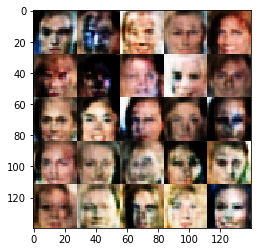

In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1,
                          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

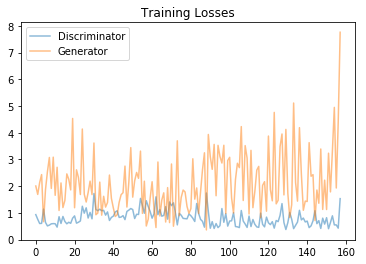

In [22]:
losses_celeba = np.array(losses_celeba)
plt.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.